
**Tasks**

* Plot heatmap of population correlation matrix across **different area pairs using Allendata**. (remember to see the structure relation across areas)
* Plot the population correlation as the function of the **time delay between areas ($t_2$-$t_1$)**
  
   * remember to delete the head and tail of stimulus time when time delay
* Consider population correlation of **different stimulus periods**, such as "Early Evoked, 160ms after stimulus onset" and "Late Evoked, 1120ms after stimulus onset"
* Generalize feedforward (FF) canonical dimensions to feedback-dominated period

*population correlation*: Correlation value for the first canonical pair as a measure of inter-areal intercation strength

In [3]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import CCA

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

## Allen data preprocessing
Get AllenData sessions

In [4]:
# basepath = "E:\Allensdk_data\local\ecephys_cache_dir"
basepath = "/home/jialab/Allensdk_data/local/ecephys_cache_dir/"
manifest_path = os.path.join(basepath, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()

Select a session randomly

In [5]:
session_id = 799864342
session = cache.get_session_data(session_id)

print(session.structure_acronyms)
print(session.stimulus_names)

['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
['spontaneous', 'gabors', 'flashes', 'drifting_gratings', 'natural_movie_three', 'natural_movie_one', 'static_gratings', 'natural_scenes', 'drifting_gratings_contrast']


Select 'drifting_gratings' stimuli with contrast 0.8 and temporal_frequency 15.0, but 8 different orientations. 
Each stimuli was presented 15 times for 2 seconds

In [5]:
stim_table = session.get_stimulus_table('drifting_gratings')
print(stim_table['temporal_frequency'].value_counts())

stim_orientation_table = stim_table[stim_table['temporal_frequency'] == 15.0 ]
print(stim_orientation_table['orientation'].value_counts())
print(stim_orientation_table['stimulus_condition_id'].value_counts())
stim_orientation_table.head()

15.0    120
8.0     120
4.0     120
2.0     120
1.0     120
null     30
Name: temporal_frequency, dtype: int64
270.0    15
45.0     15
315.0    15
90.0     15
135.0    15
180.0    15
225.0    15
0.0      15
Name: orientation, dtype: int64
254    15
252    15
248    15
247    15
277    15
272    15
267    15
256    15
Name: stimulus_condition_id, dtype: int64


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3800,0.8,45,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1596.315739,2,drifting_gratings,1598.317439,15,2.00170,248
3805,0.8,0,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1611.328291,2,drifting_gratings,1613.329971,15,2.00168,252
3807,0.8,90,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1617.333321,2,drifting_gratings,1619.334971,15,2.00165,254
3809,0.8,315,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1623.338331,2,drifting_gratings,1625.340001,15,2.00167,256


In [6]:
def spike_matrix(area, stim_table, bin=0.1):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        bin -- _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, 2 + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    # convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
    # to stimulus_bins_counts * units,

    response_matrix = response_matrix.reshape(response_matrix.shape[0]*response_matrix.shape[1], response_matrix.shape[2])

    return response_matrix

(2400, 29)


Text(0, 0.5, 'spike counts')

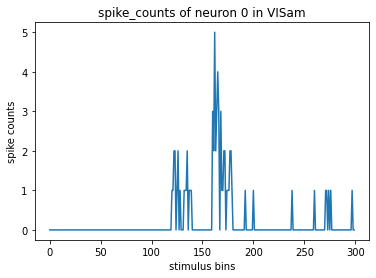

In [7]:
response_matrix_VISam = spike_matrix(area='VISam', stim_table=stim_orientation_table)

print(response_matrix_VISam.shape)

plt.figure()
plt.plot(response_matrix_VISam[:300, 0])
plt.title('spike_counts of neuron 0 in VISam')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

(2400, 44)


Text(0, 0.5, 'spike counts')

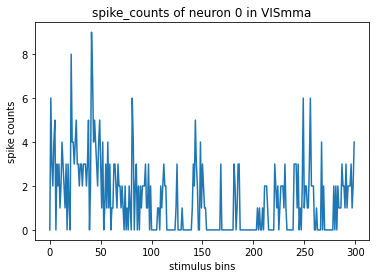

In [8]:
response_matrix_VISmma = spike_matrix(area = 'VISmma', stim_table=stim_orientation_table)

print(response_matrix_VISmma.shape)

plt.figure()
plt.plot(response_matrix_VISmma[:300, 0])
plt.title('spike_counts of neuron 0 in VISmma')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

In [9]:
def corr_area_pairs(X_a, X_b, n_components = 3):
    """corr_area_pairs _summary_

    _extended_summary_

    Arguments:
        X_a -- _description_
        X_b -- _description_
    """

    # # Standardize data to zero mean and unit variance
    # X_a = (X_a - X_a.mean(axis=0)) / X_a.std(axis=0)
    # X_b = (X_b - X_b.mean(axis=0)) / X_b.std(axis=0)

    cca = CCA(n_components, max_iter=1000)
    cca.fit(X_a, X_b)
    z_a, z_b = cca.transform(X_a, X_b) 

    # get weight after cca
    w_a = cca.x_rotations_
    w_b = cca.y_rotations_
    
    # get correlation of hidden z
    corr_z = np.empty(n_components)
    for i in range(n_components):
        corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

    return corr_z, (w_a, w_b), (z_a, z_b)

In [10]:
corr_VISam_VISmma, w_ab, z_ab = corr_area_pairs(response_matrix_VISam, response_matrix_VISmma)

print(corr_VISam_VISmma)

[0.70580206 0.68787211 0.47318666]


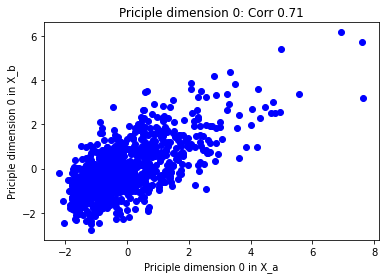

In [11]:
component = 0 # principle components
n_samples = 1000

z_a = z_ab[0]
z_b = z_ab[1]

z_a = z_a[:, component]
z_b = z_b[:, component]

fig, ax = plt.subplots()
ax1 = ax.scatter(z_a[:n_samples], z_b[:n_samples], c='blue')

ax.set_xlabel(f'Priciple dimension {component} in X_a')
ax.set_ylabel(f'Priciple dimension {component} in X_b')
ax.set_title(f'Priciple dimension {component}: Corr {corr_VISam_VISmma[component]:.2f}')
plt.show()


**Task1**

* Plot heatmap of population correlation matrix across **different area pairs using Allendata**. (remember to see the structure relation across areas)

In [12]:
areas = session.structure_acronyms
print(len(areas))
print(areas)

# delete nan in areas
while np.nan in areas:
    areas.remove(np.nan)
print(len(areas))
print(areas)

# delete area with no units
for area in areas:
    units = session.units[session.units["ecephys_structure_acronym"] == area]
    if units.shape[0] == 0:
        areas.remove(area)
print(len(areas))
print(areas)

18
['VISam', nan, 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
17
['VISam', 'COAa', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']
16
['VISam', 'CA1', 'LP', 'DG', 'VISmma', 'VISp', 'ProS', 'SUB', 'CA3', 'CA2', 'VISl', 'VISal', 'LGd', 'VISrl', 'APN', 'POL']


In [13]:
areas_corr_matrix = np.empty([len(areas), len(areas)])

for i in range(len(areas)):
    for j in range(len(areas)):
        res_mat_i = spike_matrix(area = areas[i], stim_table=stim_orientation_table)
        res_mat_j = spike_matrix(area = areas[j], stim_table=stim_orientation_table)

        corr_ij, w, z = corr_area_pairs(res_mat_i, res_mat_j)
        areas_corr_matrix[i, j] = corr_ij[0]

print(areas_corr_matrix.shape)
# print(areas_corr_matrix)


(16, 16)


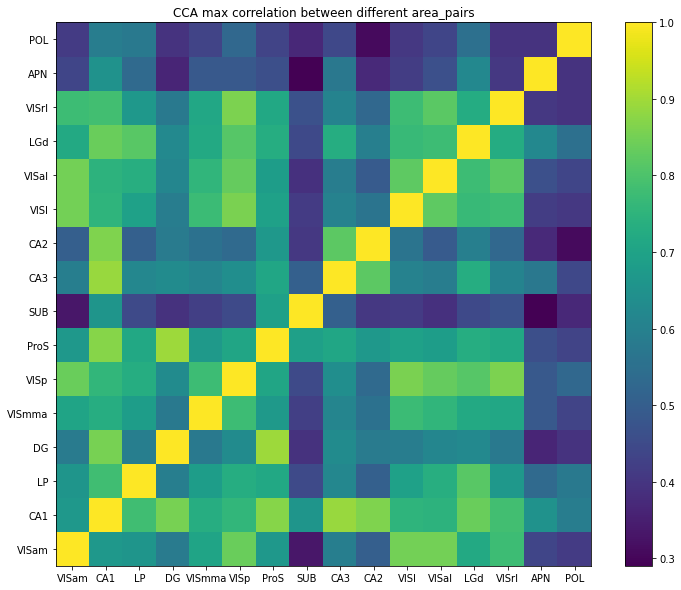

In [14]:
f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas))+np.array([0.5]))
ax.set_xticklabels(areas)
ax.set_yticks(range(len(areas))+np.array([0.5]))
ax.set_yticklabels(areas)
ax.set_title('CCA max correlation between different area_pairs')

f.colorbar(im)

plt.show()

**Results**

* After observe the correlation map, we can see that Visual cortex has more correlation with other areas
* SUB, APN, POL perform bad with other areas
* CA1, CA2 CA3 are correlated with each other more than others.

[ 29.  40.  52.  29.  75.  51.  70.  20.  36. 109.   9.  16.   7.  11.
   6.]
(15, 15)


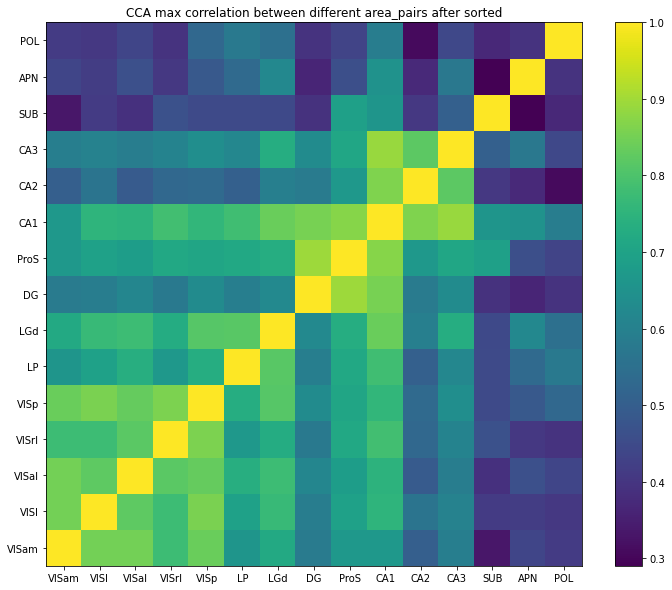

In [15]:
# Sort the areas after observation

areas_sorted = ['VISam', 'VISl', 'VISal', 'VISrl', 'VISp', 'LP', 'LGd', 'DG', 'ProS', 'CA1', 'CA2', 'CA3', 'SUB', 'APN', 'POL']
areas_units_num = np.empty(len(areas_sorted))

areas_corr_matrix = np.empty([len(areas_sorted), len(areas_sorted)])

for i in range(len(areas_sorted)):
    res_mat_i = spike_matrix(area = areas_sorted[i], stim_table=stim_orientation_table)
    areas_units_num[i] = res_mat_i.shape[1]

    for j in range(len(areas_sorted)):
        
        res_mat_j = spike_matrix(area = areas_sorted[j], stim_table=stim_orientation_table)

        corr_ij, w, z = corr_area_pairs(res_mat_i, res_mat_j)
        areas_corr_matrix[i, j] = corr_ij[0]
    
print(areas_units_num)
print(areas_corr_matrix.shape)

f, ax = plt.subplots(figsize=(12, 10))
im = ax.pcolormesh(areas_corr_matrix)

ax.set_xticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_xticklabels(areas_sorted)
ax.set_yticks(range(len(areas_sorted))+np.array([0.5]))
ax.set_yticklabels(areas_sorted)
ax.set_title('CCA max correlation between different area_pairs after sorted')

f.colorbar(im)

plt.show()


Thalamus: LP, LGd, POL
VIS: VISam, VISI, VISal, VISp, VISrl
Hypocampus: DG, CA1, CA2, CA3
RetroHypocampus:SUB, ProS
Midbrain:APN

**Questions:** whether we can find a complete information flow chain across areas via CCA?

* evaluated the directed functional connectivity using spike cross-correlograms (CCG) across different areas
* so CCA can also? And with more presice spatial resolution?

**Task2**
* Plot the population correlation as the function of the **time delay between areas ($t_2$-$t_1$)**
  
   * remember to delete the head and tail of stimulus time when time delay

In [16]:
# control stimulus, freq = 15, ori = 135
stim_delay = stim_table[(stim_table['temporal_frequency'] == 15.0) & (stim_table['orientation'] == 135.0) ]
print(stim_delay['orientation'].value_counts())
print(stim_delay['stimulus_condition_id'].value_counts())
stim_delay.head()

135.0    15
Name: orientation, dtype: int64
247    15
Name: stimulus_condition_id, dtype: int64


,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3799,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1593.313231,2,drifting_gratings,1595.314911,15,2.00168,247
3847,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1737.433701,2,drifting_gratings,1739.435391,15,2.00169,247
3861,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,1779.468851,2,drifting_gratings,1781.470531,15,2.00168,247
31015,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,3223.676099,5,drifting_gratings,3225.677789,15,2.00169,247
31042,0.8,135,"[42471.86666667, 42471.86666667]","[250.0, 250.0]",0.04,3304.743891,5,drifting_gratings,3306.745561,15,2.00167,247


In [17]:
def trials_averaged_spike_matrix(area, stim_table, bin=0.1):
    """spike_matrix _summary_

    _extended_summary_

    Arguments:
        area -- _description_
        bin -- _description_
    """

    area_units = session.units[session.units["ecephys_structure_acronym"] == area]

    time_bins = np.arange(0, 2 + bin, bin)  

    spike_counts = session.presentationwise_spike_counts(
        stimulus_presentation_ids=stim_table.index.values,  
        bin_edges=time_bins,
        unit_ids=area_units.index.values
    )
    
    response_matrix = spike_counts.values

    # convert spike_counts structure from stimulus_presentation_id*time_bins* unit_id 
    # to stimulus_bins_counts * units,
    
    response_matrix = response_matrix.sum(axis=0)

    return response_matrix

(200, 44)


Text(0, 0.5, 'spike counts')

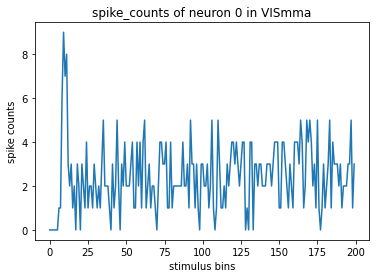

In [18]:
trial_res_mat_VISmma = trials_averaged_spike_matrix(area='VISmma', stim_table=stim_delay, bin=0.01)
print(trial_res_mat_VISmma.shape)

plt.figure()
plt.plot(trial_res_mat_VISmma[:, 0])
plt.title('spike_counts of neuron 0 in VISmma')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

(200, 29)


Text(0, 0.5, 'spike counts')

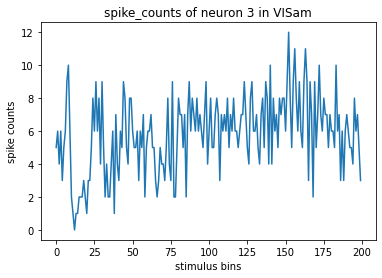

In [19]:
trial_res_mat_VISam = trials_averaged_spike_matrix(area='VISam', stim_table=stim_delay, bin=0.01)
print(trial_res_mat_VISam.shape)

plt.figure()
plt.plot(trial_res_mat_VISam[:, 3])
plt.title('spike_counts of neuron 3 in VISam')
plt.xlabel('stimulus bins')
plt.ylabel('spike counts')

In [20]:
corr_VISmma_am, w, z = corr_area_pairs(trial_res_mat_VISam, trial_res_mat_VISmma)
print(corr_VISmma_am)

[0.80827655 0.77765133 0.76667183]


**Bug:** So strange, I can only get corr of *corr_area_pairs(trial_res_mat_VISam, trial_res_mat_VISmma)* with certain num points or certain neurons. such as, 158 is ok, but 200 can't!

**Error:** ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Debug:** The 39th column of trial_res_mat_VISmma is all 0, thus when Standardize in *corr_area_pairs*, X_b will has one columu of nan, which cause the error.

**Solution:** Now I will delete the *Standardize* part in function *corr_area_pairs*, it is not necessary.

In [21]:
# Use the following codes to find the bug mentioned above

# a = response_matrix_VISam
# b = response_matrix_VISmma

a = trial_res_mat_VISam
b = trial_res_mat_VISmma

# # Standardize data to zero mean and unit variance
# a = (a - a.mean(axis=0)) / a.std(axis=0)
# b = (b - b.mean(axis=0)) / b.std(axis=0)

print(a.shape)
print(b.shape)

#True：有缺失值
print(np.isnan(b).any())

#检查是否包含无穷数据
#False:包含
#True:不包含
print(np.isfinite(b).all())
print(np.isinf(b).all())

n = 4

cca = CCA(n_components=n)
cca.fit(a, b)
z_a, z_b = cca.transform(a, b)
# get weight after cca
w_a = cca.x_rotations_
w_b = cca.y_rotations_

# get correlation of hidden z

corr_z = np.empty(n)
for i in range(n):
    corr_z[i] = np.corrcoef(z_a[:, i], z_b[:, i])[0, 1]

print(corr_z)

(200, 29)
(200, 44)
False
True
False
[0.80827655 0.77765133 0.76667183 0.70041214]


Text(0, 0.5, 'corrlelation')

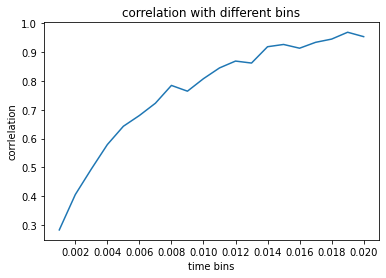

In [141]:
# plot correlation between VISam and VISmma contrast to different bins
num = 20
bins = (np.arange(num) + 1) / 1000
corr_array_bins = np.empty(num)

for i in np.arange(len(bins)):
    mat_VISmma = trials_averaged_spike_matrix(area='VISmma', stim_table=stim_delay, bin=bins[i])
    mat_VISam = trials_averaged_spike_matrix(area='VISam', stim_table=stim_delay, bin=bins[i])
    corr, w, z = corr_area_pairs(mat_VISam, mat_VISmma)
    corr_array_bins[i] = corr[0]

plt.figure()
plt.plot(bins, corr_array_bins)
plt.title('correlation with different bins')
plt.xlabel('time bins')
plt.xticks((np.arange(10)+1)*2/1000)
plt.ylabel('corrlelation')

(200, 44)
(200, 29)


Text(0, 0.5, 'corrlelation')

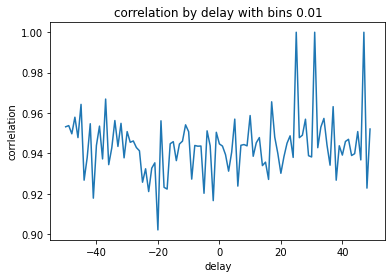

In [142]:
# correlation by delay when time bin = 0.01, with delay
bin_num = 0.01

mat_VISmma = trials_averaged_spike_matrix(area='VISmma', stim_table=stim_delay, bin=bin_num)
mat_VISam = trials_averaged_spike_matrix(area='VISam', stim_table=stim_delay, bin=bin_num)

print(mat_VISmma.shape)
print(mat_VISam.shape)

window = 100

t_VISam = 50
t_VISmma = np.arange(window)
delay = t_VISmma - t_VISam

corr_array_delay = np.empty(window)

for t in np.arange(len(t_VISmma)):
    corr, w, z = corr_area_pairs(mat_VISam[t_VISam:t_VISam+window, :], mat_VISmma[t:t+window, :])
    corr_array_delay[t] = corr[0]

plt.figure()
plt.plot(delay, corr_array_delay)
plt.title(f'correlation by delay with bins {bin_num}')
plt.xlabel('delay')
plt.ylabel('corrlelation')

(2000, 44)
(2000, 29)


Text(0, 0.5, 'corrlelation')

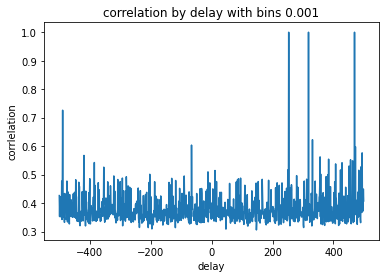

In [143]:
# correlation by delay when time bin = 0.001, with delay
bin_num = 0.001

mat_VISmma = trials_averaged_spike_matrix(area='VISmma', stim_table=stim_delay, bin=bin_num)
mat_VISam = trials_averaged_spike_matrix(area='VISam', stim_table=stim_delay, bin=bin_num)

print(mat_VISmma.shape)
print(mat_VISam.shape)

window = 1000

t_VISam = 500
t_VISmma = np.arange(window)
delay = t_VISmma - t_VISam

corr_array_delay = np.empty(window)

for t in np.arange(len(t_VISmma)):
    corr, w, z = corr_area_pairs(mat_VISam[t_VISam:t_VISam+window, :], mat_VISmma[t:t+window, :])
    corr_array_delay[t] = corr[0]

plt.figure()
plt.plot(delay, corr_array_delay)
plt.title(f'correlation by delay with bins {bin_num}')
plt.xlabel('delay')
plt.ylabel('corrlelation')

(2000, 44)
(2000, 29)
40
1700
[1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613
 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627
 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641
 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655
 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669
 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683
 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697
 1698 1699 1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711
 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724 1725
 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738 1739
 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752 1753
 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766 1767
 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781
 1782 1783 1784 1785 1786 1787 1788 1789 1790 1

Text(0, 0.5, 'corrlelation')

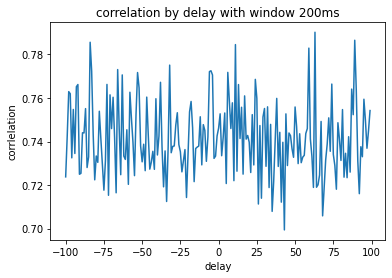

In [146]:
# correlation by delay when time bin = 1ms, with window 100ms, window slide advanced 40ms

stim_time = 2000 # stimulus time 2000ms
bin_num = 0.001  # bin time 1ms

mat_VISmma = trials_averaged_spike_matrix(area='VISmma', stim_table=stim_delay, bin=bin_num)
mat_VISam = trials_averaged_spike_matrix(area='VISam', stim_table=stim_delay, bin=bin_num)

print(mat_VISmma.shape)
print(mat_VISam.shape)

window = 200      # window time when calulate corr
step_time = 40         # advanced time step of window

t_VISam = int(window / 2)    # relative start time of VISam
t_VISmma = np.arange(window)    # relative start time of VISmma
delay = t_VISmma - t_VISam

step_num = int((stim_time - 2*window) / step_time)
print(step_num)
corr_matrix_delay = np.empty((step_num, window))

for step in np.arange(step_num):
    t_VISam = t_VISam + step_time
    t_VISmma = t_VISmma + step_time
    for i_t in np.arange(len(t_VISmma)):
        corr, w, z = corr_area_pairs(mat_VISam[t_VISam:t_VISam+window, :], mat_VISmma[t_VISmma[i_t]:t_VISmma[i_t]+window, :])
        corr_matrix_delay[step, i_t] = corr[0]

# print(t_VISam)
# print(t_VISmma)

print(corr_matrix_delay.shape)
corr_matrix_delay = corr_matrix_delay.mean(0)
print(corr_matrix_delay.shape)

plt.figure()
plt.plot(delay, corr_matrix_delay)
plt.title(f'correlation by delay with window {window}ms')
plt.xlabel('delay')
plt.ylabel('corrlelation')

(2000, 109)
(2000, 16)
40
1700
[1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613
 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627
 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641
 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655
 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669
 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683
 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697
 1698 1699 1700 1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711
 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724 1725
 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738 1739
 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752 1753
 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766 1767
 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781
 1782 1783 1784 1785 1786 1787 1788 1789 1790 

Text(0, 0.5, 'corrlelation')

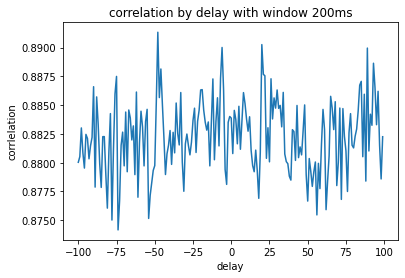

In [147]:
# try other areas, such CA1 & CA3
# correlation by delay when time bin = 1ms, with window 100ms, window slide advanced 40ms

stim_time = 2000 # stimulus time 2000ms
bin_num = 0.001  # bin time 1ms

mat_area1 = trials_averaged_spike_matrix(area='CA1', stim_table=stim_delay, bin=bin_num)
mat_area2 = trials_averaged_spike_matrix(area='CA3', stim_table=stim_delay, bin=bin_num)

print(mat_area1.shape)
print(mat_area2.shape)

window = 200      # window time when calulate corr
step_time = 40         # advanced time step of window

t_area1 = int(window / 2)    # relative start time of VISam
t_area2 = np.arange(window)    # relative start time of VISmma
delay = t_area2 - t_area1

step_num = int((stim_time - 2*window) / step_time)
print(step_num)
corr_matrix_delay = np.empty((step_num, window))

for step in np.arange(step_num):
    t_area1 = t_area1 + step_time
    t_area2 = t_area2 + step_time
    for i_t in np.arange(len(t_area2)):
        corr, w, z = corr_area_pairs(mat_area1[t_area1:t_area1+window, :], mat_area2[t_area2[i_t]:t_area2[i_t]+window, :])
        corr_matrix_delay[step, i_t] = corr[0]

# print(t_area1)
# print(t_area2)

print(corr_matrix_delay.shape)
corr_matrix_delay = corr_matrix_delay.mean(0)
print(corr_matrix_delay.shape)

plt.figure()
plt.plot(delay, corr_matrix_delay)
plt.title(f'correlation by delay with window {window}ms')
plt.xlabel('delay')
plt.ylabel('corrlelation')

In [156]:
# try other areas

def plot_corr_delay(area1, area2, stim_delay, stim_onset=0, stim_time=2000, bin_num=0.001, window=200, step_time=40):
    """plot_corr_delay _summary_

    correlation by delay when time bin = 1ms, with window 100ms, window slide advanced 40ms

    Arguments:
        area1 -- _description_
        area2 -- _description_
        stim_delay -- _description_

    Keyword Arguments:
        stim_time -- stimulus time (default: {2000})
        bin_num -- bin time (default: {0.001})
        window -- window time when calulate corr (default: {200})
        step_time -- advanced time step of window (default: {40})
    """

    mat_area1 = trials_averaged_spike_matrix(area=area1, stim_table=stim_delay, bin=bin_num)
    mat_area2 = trials_averaged_spike_matrix(area=area2, stim_table=stim_delay, bin=bin_num)

    print(mat_area1.shape)
    print(mat_area2.shape)

    t_area1 = stim_onset + int(window / 2)    # relative start time of VISam
    t_area2 = np.arange(window)    # relative start time of VISmma
    delay = t_area2 - t_area1

    step_num = int((stim_time - 2*window) / step_time)
    print(step_num)
    corr_matrix_delay = np.empty((step_num, window))

    for step in np.arange(step_num):
        t_area1 = t_area1 + step_time
        t_area2 = t_area2 + step_time
        for i_t in np.arange(len(t_area2)):
            corr, w, z = corr_area_pairs(mat_area1[t_area1:t_area1+window, :], mat_area2[t_area2[i_t]:t_area2[i_t]+window, :])
            corr_matrix_delay[step, i_t] = corr[0]

    # print(t_area1)
    # print(t_area2)

    print(corr_matrix_delay.shape)
    corr_matrix_delay = corr_matrix_delay.mean(0)
    print(corr_matrix_delay.shape)

    plt.figure()
    plt.plot(delay, corr_matrix_delay)
    plt.title(f'correlation across {area1}&{area2}')
    plt.xlabel('delay')
    plt.ylabel('corrlelation')
    plt.show()

    return corr_matrix_delay

**Results:** Correlation don't change along time delay by CCA

**Possible explaination:**
* Areas selected don't show obvious information flow direction
* stimuli seleted presented all the time, without blank period for information feedback
* an interesting thing: 
  * smaller the time bin, smaller the correlation; 
  * smaller the window time, bigger the correlation

(2000, 70)
(2000, 75)
40
(40, 200)
(200,)


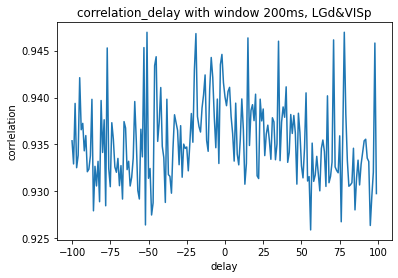

In [155]:
# try LGd & VISp
corr_matrix_delay = plot_corr_delay(area1='LGd', area2='VISp', stim_delay=stim_delay)

**Problems cued in 1v1 meeting 20220412**
* Correlation_delay data is spiky
  * If 1ms slide, data can not changed a lot
  * Try window step smaller
* Correlation_delay data is too large
* No obvious pattern in Correlation_delay data
  * Delay period longer
  * Shuffle data as refer
  * revert roles of area1 and area2 in Correlation_delay data, delta MI
  * MI_delay, delta_MI_delay, across areas
* Develop intuition for data visualization
  * small try, such PSTH, receptive-field of single unit or across units
  * See more raw data and neuro paper
* Across time & across conditions considering differently

**Task3**
* Consider population correlation of **different stimulus periods**, such as "Early Evoked, 160ms after stimulus onset" and "Late Evoked, 1120ms after stimulus onset"

(2000, 70)
(2000, 75)
15
(15, 200)
(200,)


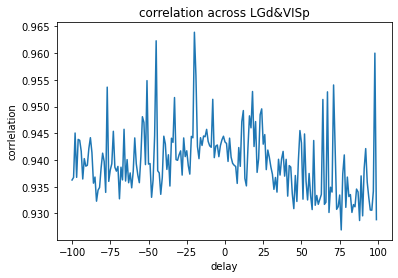

(2000, 70)
(2000, 75)
15
(15, 200)
(200,)


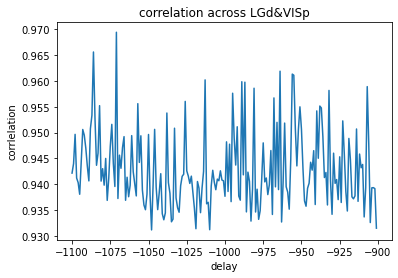

In [157]:
corr_early_evoked = plot_corr_delay(area1='LGd', area2='VISp', stim_delay=stim_delay, stim_onset=0, stim_time=1000)
corr_late_evoked = plot_corr_delay(area1='LGd', area2='VISp', stim_delay=stim_delay, stim_onset=1000, stim_time=1000)


**Task4**
* Generalize feedforward (FF) canonical dimensions to feedback-dominated period